# ANA 540: Using Decisiton tree regression ensemble for forecasting of Coronavirus Disease 2019 hospitalization rates in the state of maine 
*By Gildas Tiendrebeogo*

# I. Introduction

The Coronavirus Disease 2019 (COVID-19) pandemic has presented significant challenges for healthcare systems worldwide, necessitating effective strategies for monitoring and predicting hospitalization rates. Accurate short-term forecasting of hospitalization rates can help in resource allocation, emergency preparedness, and informed public health responses (1-2). This study focuses on developing predictive models for weekly COVID-19 hospitalization rates in the state of Maine using machine learning algorithms.

In this project, we aim to use a Decision Tree (DT) regression model as a baseline for short-term forecasting of COVID-19 weekly hospitalizations. The simplicity of Decision Trees allows for straightforward interpretability, making them a useful starting point in predictive modeling. To enhance predictive performance and address potential limitations of a single DT model, we will also compare the baseline results with more complex ensemble methods, including Random Forest and XGBoost. These models are well-suited for handling non-linearity and feature interactions, which are common in time series data. The results from this comparative analysis will provide insight into the strengths and weaknesses of using Decision Tree-based ensembles for forecasting hospitalization rates and contribute to a better understanding of model selection for forecasting disease with seasonal patterns.

## 1 Litterature review
## 1.1 Time series forecasting

In time series forecasting for infectious disease hospitalizations, various statistical and machine learning models have been explored to predict short- and long-term trends. Traditional models such as ARIMA and its seasonal variant, SARIMA, are frequently used due to their capability to model seasonality and handle autocorrelated data (3). However, with the COVID-19 pandemic's non-linear and complex patterns, advanced models like XGBoost, LSTM, and Prophet have gained traction for their ability to capture non-linear dependencies and adapt to irregular fluctuations in hospitalization data (4). Research by Chakraborty and Ghosh (5) suggests that ensemble techniques, combining machine learning with traditional time series models, often enhance forecasting accuracy by leveraging the strengths of each approach. These models are particularly useful for projecting near-term healthcare demands and allow for dynamic public health responses in light of rapidly changing conditions. In this study, we apply and evaluate the predictive power of several models, including Decision Tree Regression and XGBoost, to estimate Maine's COVID-19 hospitalization rates over the next four time steps, providing essential data for healthcare planning and resource allocation.

## 1.2 Decision tree regression
In recent years, decision tree regression has emerged as a valuable tool in time series forecasting, especially in cases where data exhibit complex patterns and non-linear relationships. Decision trees provide interpretable models by recursively partitioning the data, making them particularly useful in scenarios where understanding the importance of predictors is as valuable as accurate predictions. However, single decision trees can be prone to overfitting and may lack robustness in capturing broader trends in highly variable data, such as COVID-19 hospitalizations (6). To enhance the predictive power of decision trees, ensemble methods like Random Forest and XGBoost are commonly employed.

Random Forest builds on the strengths of decision trees by creating an ensemble of trees trained on various data subsets, then averaging the results to produce a more stable and accurate prediction (7). This method reduces the overfitting risk and captures a wider range of variability, improving predictive performance. XGBoost, a gradient-boosted decision tree algorithm, goes further by iteratively building trees where each subsequent tree focuses on reducing the errors of the previous one, effectively minimizing prediction errors through boosted learning (8). Both Random Forest and XGBoost offer substantial improvements over standalone decision trees by leveraging ensemble forecasting, providing robust predictions and enhancing model accuracy—key for forecasting COVID-19 hospitalization rates and guiding healthcare resource allocation.

## 1.3 Evaluation metrics
In evaluating the performance of time series forecasting models, particularly in predicting COVID-19 hospitalization rates, selecting appropriate metrics is essential for accurately assessing model accuracy and reliability. Cross-validation is a key method for robust evaluation, especially in cases with limited data, as it reduces variance and provides a more reliable estimate of model performance across different subsets of the data (9). By employing techniques like k-fold cross-validation, we ensure that each data point has a chance to be in both the training and testing sets, providing a comprehensive measure of model generalization.

Several metrics will be used to evaluate model performance, including R-squared (R²), Mean Squared Error (MSE), and Mean Absolute Error (MAE). R², or the coefficient of determination, measures the proportion of variance in the dependent variable that is predictable from the independent variables. Higher R² values indicate a better fit between the predicted and actual values, showing how well the model explains the data (6). MSE, which calculates the average squared difference between predicted and actual values, emphasizes larger errors and is useful for penalizing models with significant deviations. MAE, on the other hand, measures the average magnitude of errors without considering their direction, offering a more intuitive interpretation of model accuracy by averaging the absolute errors. Together, these metrics provide a balanced assessment, enabling a comprehensive comparison of model performance and helping to identify the best forecasting approach for COVID-19 hospitalization rates.

## 2 Significance of the Study
This study aims to provide a valuable short-term forecasting model for COVID-19 hospitalization rates in Maine, which is critical for enabling timely public health interventions. By accurately predicting hospitalization rates for the immediate future, this research supports healthcare providers and policymakers in anticipating potential surges and responding proactively to mitigate healthcare system strain. Short-term forecasts allow for effective resource allocation, such as adjusting hospital staffing levels, preparing ICU capacity, and ensuring adequate supplies of medical equipment.

Given Maine’s high median age, one of the nation’s most vulnerable demographics, timely interventions are essential to reduce excess hospitalizations and improve patient outcomes (10). This study highlights the importance of integrating data mining techniques—such as Decision Tree Regression combined with temporal feature engineering—to generate precise, near-term forecasts. 

# II. Data
The data for this study is sourced from the National Electronic Disease Surveillance System (NEDSS), managed by the Maine Center for Disease Control and Prevention (CDC). It includes 9,061 observations, each entry representing a confirmed COVID-19-related hospitalization reported to the Maine CDC between June 2020 and June 2024. The dataset contains one categorical variable (hospitalization status) and one date variable (earliest report date). The hospitalization status variable was used to create a count variable that summarizes the daily count of hospitalizations. This is the target variable that will be used for numeric feature engineering. The Date variable will be used to engineer temporal features.Finally, the data will be aggregated by week to form a time series, which will serve as the basis for forecasting weekly hospitalization rates. 

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning models and utilities
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model evaluation and tuning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization and interpretation
from sklearn.inspection import PartialDependenceDisplay
import shap

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [5]:
hospital = pd.read_excel('hospital.xlsx')

hospital['EARLIEST_RPT_TO_ST_DT'] = pd.to_datetime(hospital['EARLIEST_RPT_TO_ST_DT'])
hospital['start_of_week'] = hospital['EARLIEST_RPT_TO_ST_DT'].dt.to_period('W').apply(lambda x: x.start_time)

hospital = hospital.sort_values(by='start_of_week', ascending=True)

hospital_agg = hospital.groupby(['start_of_week']).agg({'HSPTLIZD_IND': 'sum'}).reset_index()
hospital_agg.rename(columns={'HSPTLIZD_IND': 'count'}, inplace=True)



## 2.1-Variable names and definition


*Table 1 : Variable names and definitions*

| Column                | Description                                                      | Non-Null Count | Data Type       |
|-----------------------|------------------------------------------------------------------|----------------|-----------------|
| `count`        | Indicator if the patient was hospitalized (1 = Yes)      | 9059           | int64           |
| `EARLIEST_RPT_TO_ST_DT` | The earliest report date to the state for the patient’s case (6/2020-6/2024)   | 9059           | datetime64[ns]  |
| `week_of_the_year`    | Week of the year (as integer) when the report was made           | 9059           | int64           |
| `year`                | Year when the report was made                                    | 9059           | int64           |
| `month`               | Month when the report was made                                   | 9059           | int64           |
| `count_lag1`          | Hospitalization count one week prior                             | 9058           | float64         |
| `count_lag2`          | Hospitalization count two weeks prior                            | 9057           | float64         |
| `count_lag3`          | Hospitalization count three weeks prior                          | 9056           | float64         |
| `rolling_mean_3`      | 3-week rolling average of hospitalization counts                 | 9057           | float64         |
| `rolling_std_3`       | 3-week rolling standard deviation of hospitalization counts      | 9057           | float64         |
| `is_start_of_season`  | Indicator for the start of a new season (March, June, Sept, Dec) | 9059           | int64           |
| `cumulative_count`    | Cumulative count of hospitalizations up to the report date       | 9059           | int64           |
| `count_diff1`         | Difference in hospitalization counts from the prior week         | 9058           | float64         |
| `exp_moving_avg_3`    | 3-week exponential moving average of hospitalization counts      | 9059           | float64         |



## 2.2-Categorical variables

In [ ]:
hospital.loc[:, 'year'] = hospital['start_of_week'].dt.year
hospital.loc[:, 'month'] = hospital['start_of_week'].dt.month
hospital.loc[:, 'week_of_year'] = hospital['start_of_week'].dt.isocalendar().week

# Create a figure with only 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plotting the first histogram (Week of the Year)
top_weeks = hospital['week_of_year'].value_counts().nlargest(10).index
sns.countplot(x='week_of_year', data=hospital, ax=axs[0], order=top_weeks)
axs[0].set_xlabel('Week of the Year')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Week of the Year')
axs[0].grid(axis='y')

# Plotting the second histogram (Months)
sns.countplot(x='month', data=hospital, ax=axs[1], order=sorted(hospital['month'].unique()))
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Months')
axs[1].set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                        'July', 'August', 'September', 'October', 'November', 'December'], rotation=90)
axs[1].grid(axis='y')

# Plotting the third histogram (Years)
sns.countplot(x='year', data=hospital, ax=axs[2], order=sorted(hospital['year'].unique()))
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of Year')
axs[2].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 1: Frequencies of Categorical Variables',
            ha='center', fontsize=11, fontstyle='italic')

# Show the figure
plt.show()

*Figure 1* illustrates the distribution of COVID-19 hospitalization counts across three categorical variables: "Week of the Year," "Month," and "Year." The histogram of "Week of the Year" reveals that the highest frequencies of hospitalizations occurred at the beginning (Week 1) and end (Week 52) of the year, with additional peaks in Weeks 49, 50, and 3. This pattern suggests an increase in hospitalizations around the holiday season and early winter months, aligning with known surges in respiratory illnesses during this period. In the "Month" histogram, the data indicates a significant increase in hospitalizations in January and December, with secondary peaks in October and November, further highlighting a seasonal pattern likely associated with colder months and higher indoor activity. The "Year" histogram shows that 2022 had the highest frequency of COVID-19 hospitalizations, followed by 2021, with a notable decline in 2023 and 2024. This downward trend could reflect the effects of vaccination efforts, increased immunity within the population, and evolving public health strategies. These temporal insights underscore the importance of seasonality and pandemic response measures in understanding and forecasting COVID-19 hospitalizations in Maine.ts.


## 2.3- Numerical variables

*Table 2: numerical variables distribution*

| Statistic              | count  | count_lag1 | count_lag2 | count_lag3 | rolling_mean_3 | rolling_std_3 | is_start_of_season | cumulative_count | count_diff1 | exp_moving_avg_3 |
|------------------------|--------|------------|------------|------------|----------------|----------------|--------------------|------------------|-------------|------------------|
| **count**              | 244    | 244        | 244        | 244        | 244            | 244            | 244                | 244              | 244         | 244              |
| **mean**               | 37.01  | 37.02      | 37.05      | 37.01      | 37.03          | 13.08          | 0.32               | 4637.34          | -0.01       | 37.01            |
| **std**                | 26.70  | 26.69      | 26.65      | 26.70      | 22.65          | 11.23          | 0.47               | 2899.55          | 23.80       | 22.40            |
| **min**                | 1.00   | 1.00       | 1.00       | 1.00       | 4.33           | 0.58           | 0.00               | 48.00            | -99.00      | 4.09             |
| **25%**                | 14.00  | 14.00      | 14.00      | 14.00      | 19.92          | 4.69           | 0.00               | 1779.00          | -10.25      | 18.97            |
| **50%** (median)       | 32.50  | 32.50      | 32.50      | 32.50      | 33.83          | 10.52          | 0.00               | 4842.50          | 1.00        | 34.79            |
| **75%**                | 54.00  | 54.00      | 54.00      | 54.00      | 52.50          | 17.93          | 1.00               | 7208.50          | 8.25        | 51.77            |
| **max**                | 141.00 | 141.00     | 141.00     | 141.00     | 109.67         | 60.53          | 1.00               | 9059.00          | 121.00      | 100.18           |


Table 2 provides the summary statistics for the numerical variables. For intance the maximum weekly hospitalization count for the whole period was 141.

## 2.4-time series data
### 2.4.1- Autocorrelation plots

In [ ]:
# Set the index for the time series
##hospital_agg['start_of_week'] = pd.to_datetime(hospital_agg['start_of_week'])
#hospital_agg.set_index('start_of_week', inplace=True)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(2, 1, 1)
plot_acf(hospital_agg['count'], lags=10, ax=plt.gca())  # Adjust lags as needed
plt.title('Autocorrelation Function of weekly hospitalization counts (ACF)')

# Plot PACF
plt.subplot(2, 1, 2)
plot_pacf(hospital_agg['count'], lags=10, ax=plt.gca(), method='ywm')  # Adjust lags as needed
plt.title('Partial Autocorrelation Function of weekly hospitalization counts (PACF)')

plt.tight_layout()

# Add the main title at the bottom
plt.figtext(0.5, -0.02, 'Figure 2: ACF and PACF graph of weekly hospitalization count time series',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()
# Reset index to maintain original structure
hospital_agg.reset_index(inplace=True)


*Figure 2* displays the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots of weekly hospitalization counts. The ACF plot, shown at the top, highlights the correlation between the time series and its lagged values, with significant spikes at lags 1, 2, 3, and beyond, indicating strong correlations that gradually decrease. This pattern suggests potential non-stationarity or a persistent trend in the data. The shaded area represents the 95% confidence interval, where any spike outside this range is statistically significant. The PACF plot, at the bottom, measures the correlation of the series with its lagged values while controlling for the influence of shorter lags. Here, the significant spike at lag 1 indicates that an autoregressive model of order 1 (AR(1)) might be appropriate, as the subsequent lags fall within the confidence interval and are not significant. Together, these plots suggest that an AR(1) model may adequately capture the time series' structure, guiding the choice of parameters. For our analysis we will keep temporal variables lag order within the range of 1-3. After fitting the model, feature importance will be plotted to evaluate which features have the most predictive power.

### 2.4.2 time series plot

In [ ]:
plt.figure(figsize=(12, 6))
# Use log1p for numerical stability
#hospital_agg['log_count'] = np.log1p(hospital_agg['count'])

# Create a line plot for hospitalization counts over time using start_of_week
sns.lineplot(data=hospital_agg, x='start_of_week', y='count', marker='o', color='blue')

# Set titles and labels

plt.xlabel('Start of Week', fontsize=12, fontweight='bold')
plt.ylabel('Hospitalization Count', fontsize=12, fontweight='bold')

# Format the x-axis to show dates at a 45-degree angle
plt.xticks(rotation=45)
plt.xlim(hospital_agg['start_of_week'].min(), hospital_agg['start_of_week'].max())

# Set a grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 3: Weekly COVID-19 Hospitalization Counts Over Time',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()


*Figure 3* depicts the weekly COVID-19 hospitalization counts over time, spanning from mid-2020 to early 2024. The x-axis represents the start of each week, while the y-axis shows the number of hospitalizations recorded during that week. The trend shows significant fluctuations in hospitalization counts, indicating multiple waves of increased COVID-19 activity. Notable peaks are observed around early 2021, early 2022, and late 2023, suggesting periods of heightened transmission or severe outbreaks. Between these peaks, there are visible declines and relatively stable periods, indicating reduced hospitalization rates. The overall pattern suggests cyclical surges that may be influenced by factors such as new variants, public health measures, or vaccination campaigns. This visualization highlights the dynamic and periodic nature of the COVID-19 pandemic's impact on hospital systems. It also highlights the complex distribution of weekly forecast data.

# III- Methods
## 1-Maine COVID-19 enhanced surveillance system
The Maine CDC collects data on COVID-19 cases, encompassing hospitalizations, outbreaks, and deaths, as part of its advanced surveillance efforts, which also incorporate syndromic surveillance. The CDC's COVID Net defines a COVID-19 hospitalization as the admission of any patient to a hospital within 14 days following a laboratory-confirmed SARS-CoV-2 diagnosis, irrespective of the admission reason(11). Upon case reporting, a trained investigator is tasked with verifying the hospitalization status, gathering details on exposure, and documenting hospitalization specifics such as admission and release dates, as well as whether the patient was admitted to the ICU. The investigation concludes when the patient is either discharged or succumbs to the illness in the hospital.
## 2-Hospitalization rates
In this study, the hospitalization rate represents the weekly count of all reported COVID-19 hospitalizations in the state of Maine. This measure includes every confirmed COVID-19 case resulting in hospitalization within the specified week, as reported to the Maine CDC. By aggregating hospitalizations by week, this rate provides a time-based metric that reflects the overall burden of COVID-19 on the healthcare system across the study period. This weekly count serves as the primary outcome variable, enabling analysis of temporal trends in COVID-19 hospitalizations and supporting predictive modeling efforts.

## 3-Statistical Analysis (Decision tree regression)
### 3.1- Description
For our statistical analysis, we will employ and compare three machine learning models: Decision Tree (DT), Random Forest (RF), and XGBoost. These models provide a balance between interpretability and predictive power, enabling us to understand the contribution of different seasonal patterns to COVID-19 hospitalizations. The features under consideration include the day of the week, month, year, and a series of numerical features such as lagged counts and rolling means of consecutive periods to help the models capture temporal dependencies in the time series data (6).

The Decision Tree model operates by recursively partitioning the data based on feature values, creating a hierarchical structure that captures nonlinear relationships and interactions between variables. At each node, the feature and threshold that best split the data are selected using metrics such as Gini impurity or entropy. This interpretability makes the Decision Tree particularly useful for explaining predictions and providing a visual representation of the decision-making process.

In contrast, the Random Forest model builds an ensemble of decision trees, each trained on a bootstrap sample of the data and a random subset of features. By aggregating the predictions of multiple trees, Random Forest reduces the risk of overfitting and improves generalization performance. It also provides feature importance measures, which help in understanding the relative influence of each predictor (7).

XGBoost, an advanced gradient boosting algorithm, constructs trees sequentially, with each new tree aiming to correct the errors of the previous ones. Known for its high performance and efficiency, especially with large and complex datasets, XGBoost offers feature importance metrics and can capture intricate patterns in the data through its boosting mechanism (8).

To determine the best-performing model for our analysis, we will employ cross-validation techniques. Specifically, we will use k-fold cross-validation (e.g., k=5) to evaluate each model's performance across different subsets of the data. This method provides a comprehensive assessment of each model's predictive accuracy and stability, ensuring that our comparison accounts for variability in the data. Key performance metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared will be used to compare the models (9).

For the best-performing model identified through cross-validation, we will apply a grid search procedure for hyperparameter tuning before using the model to forecast 4 weeks into the future

### 3.2-Train/test split
In this study, a time-based train-test split is employed to preserve the temporal structure of the data, which is essential for time series analysis. By allocating 70% of the dataset to the training set and the remaining 30% to the test set, we ensure that the model learns patterns from historical data and is then evaluated on future data that it hasn’t encountered. This is achieved by calculating the number of rows that constitute 70% of the dataset length and then using this to split the dataset sequentially: the first 70% of the observations are designated as train_data, while the last 30% are assigned as test_data. This method mirrors real-world forecasting, where models are built on past data to predict future values, and avoids "data leakage" that could arise from including future observations in the training set. This setup provides a realistic evaluation of the model’s predictive accuracy.

### 3.3- Feature engineering 

In the feature engineering process, temporal features were extracted from the time series data by creating columns for the year, month, and week of the year based on the start of the week variable. After splitting the data into training and testing sets to prevent data leakage, a comprehensive feature engineering process is applied to the time series forecasting task. This process involves creating features that can capture temporal dependencies from historical data such as  count_lag1. Rolling statistics, such as rolling means and standard deviations (e.g., rolling_mean_3, rolling_std_3), are computed to smooth data and identify trends. Time-based features, like is_start_of_season, are added to represent seasonality and periodic effects. Cumulative counts are created to understand the total progression over time, while exponential moving averages (EMA), such as exp_moving_avg_3, provide a smoothed trend analysis (12). Importantly, this feature engineering process is conducted after the train-test split to ensure that all engineered features use only past data, thus preventing data leakage and preserving the integrity of the model evaluation.

In [6]:
hospital_agg.loc[:, 'year'] = hospital_agg['start_of_week'].dt.year
hospital_agg.loc[:, 'month'] = hospital_agg['start_of_week'].dt.month
hospital_agg.loc[:, 'week_of_year'] = hospital_agg['start_of_week'].dt.isocalendar().week

df = hospital_agg.drop(columns=['start_of_week'])

# Train-test split based on time
train_size = int(len(df) * 0.7)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]# 1. Lag Features
train_data['count_lag1'] = train_data['count'].shift(1)
train_data['count_lag2'] = train_data['count'].shift(2)
train_data['count_lag3'] = train_data['count'].shift(3)

# 2. Rolling Statistics
train_data['rolling_mean_3'] = train_data['count'].rolling(window=3).mean()
train_data['rolling_std_3'] = train_data['count'].rolling(window=3).std()

# 3. Interaction Terms
#train_data['month_day_interaction'] = train_data['month'] * train_data['day_of_week']

# 4. Time Features
train_data['is_start_of_season'] = train_data['month'].apply(lambda x: 1 if x in [3, 6, 9, 12] else 0)

# 6. Cumulative Counts
train_data['cumulative_count'] = train_data['count'].cumsum()

# 7. Difference Features
train_data['count_diff1'] = train_data['count'] - train_data['count'].shift(1)

# 8. Exponential Moving Average
train_data['exp_moving_avg_3'] = train_data['count'].ewm(span=3, adjust=False).mean()

# Drop rows with missing values due to lagging or rolling operations
train_data.dropna(inplace=True)
train_data['time_index'] = np.arange(1, len(train_data) + 1)

# 1. Lag Features
test_data['count_lag1'] = test_data['count'].shift(1)
test_data['count_lag2'] = test_data['count'].shift(2)
test_data['count_lag3'] = test_data['count'].shift(3)

# 2. Rolling Statistics
test_data['rolling_mean_3'] = test_data['count'].rolling(window=3).mean()
test_data['rolling_std_3'] = test_data['count'].rolling(window=3).std()

# 3. Interaction Terms
#test_data['month_day_interaction'] = test_data['month'] * test_data['day_of_week']

# 4. Time Features
test_data['is_start_of_season'] = test_data['month'].apply(lambda x: 1 if x in [3, 6, 9, 12] else 0)

# 6. Cumulative Counts
test_data['cumulative_count'] = test_data['count'].cumsum()

# 7. Difference Features
test_data['count_diff1'] = test_data['count'] - test_data['count'].shift(1)

# 8. Exponential Moving Average
test_data['exp_moving_avg_3'] = test_data['count'].ewm(span=3, adjust=False).mean()

# Drop rows with missing values due to lagging or rolling operations
test_data.dropna(inplace=True)
test_data['time_index'] = np.arange(1, len(test_data) + 1)

# Perform feature engineering on train_data and test_data as per your existing code

# Extract the feature column order from train_data
feature_order = list(train_data.columns)

# Ensure test_data has the same columns in the same order as train_data
test_data = test_data[feature_order]

# Check if train_data and test_data columns are now aligned
#print("Train data columns:", train_data.columns)
#print("Test data columns:", test_data.columns)


# 1. Lag Features
train_data['count_lag1'] = train_data['count'].shift(1)
train_data['count_lag2'] = train_data['count'].shift(2)
train_data['count_lag3'] = train_data['count'].shift(3)

# 2. Rolling Statistics
train_data['rolling_mean_3'] = train_data['count'].rolling(window=3).mean()
train_data['rolling_std_3'] = train_data['count'].rolling(window=3).std()

# 3. Interaction Terms
#train_data['month_day_interaction'] = train_data['month'] * train_data['day_of_week']

# 4. Time Features
train_data['is_start_of_season'] = train_data['month'].apply(lambda x: 1 if x in [3, 6, 9, 12] else 0)

# 6. Cumulative Counts
train_data['cumulative_count'] = train_data['count'].cumsum()

# 7. Difference Features
train_data['count_diff1'] = train_data['count'] - train_data['count'].shift(1)

# 8. Exponential Moving Average
train_data['exp_moving_avg_3'] = train_data['count'].ewm(span=3, adjust=False).mean()

# Drop rows with missing values due to lagging or rolling operations
train_data.dropna(inplace=True)
train_data['time_index'] = np.arange(1, len(train_data) + 1)

# 1. Lag Features
test_data['count_lag1'] = test_data['count'].shift(1)
test_data['count_lag2'] = test_data['count'].shift(2)
test_data['count_lag3'] = test_data['count'].shift(3)

# 2. Rolling Statistics
test_data['rolling_mean_3'] = test_data['count'].rolling(window=3).mean()
test_data['rolling_std_3'] = test_data['count'].rolling(window=3).std()

# 3. Interaction Terms
#test_data['month_day_interaction'] = test_data['month'] * test_data['day_of_week']

# 4. Time Features
test_data['is_start_of_season'] = test_data['month'].apply(lambda x: 1 if x in [3, 6, 9, 12] else 0)

# 6. Cumulative Counts
test_data['cumulative_count'] = test_data['count'].cumsum()

# 7. Difference Features
test_data['count_diff1'] = test_data['count'] - test_data['count'].shift(1)

# 8. Exponential Moving Average
test_data['exp_moving_avg_3'] = test_data['count'].ewm(span=3, adjust=False).mean()

# Drop rows with missing values due to lagging or rolling operations
test_data.dropna(inplace=True)
test_data['time_index'] = np.arange(1, len(test_data) + 1)

# Perform feature engineering on train_data and test_data as per your existing code

# Extract the feature column order from train_data
feature_order = list(train_data.columns)

# Ensure test_data has the same columns in the same order as train_data
test_data = test_data[feature_order]

# Check if train_data and test_data columns are now aligned
##print("Test data columns:", test_data.columns)



# IV-Results
## 4.1- Model fitting
### 4.1.1- Performance metrics evaluation

* Decision tree

In [7]:
# Defining features and target variable
X_train = train_data.drop(columns=['count'])
y_train = train_data['count']
X_test = test_data.drop(columns=['count'])
y_test = test_data['count']

# Step 3: Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)

# Step 4: Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation and print the mean R^2 score
cv_scores = cross_val_score(tree, X_train, y_train, cv=tscv, scoring='r2')

# Print the cross-validation scores
print("Cross-validation R^2 scores:", cv_scores)
print("Mean cross-validation R^2 score:", np.mean(cv_scores))

# Step 5: Train the Decision Tree on the entire training data
tree.fit(X_train, y_train)

# Step 6: Test the model on the test data
y_pred = tree.predict(X_test)

# Optional: Evaluate the model on the test data
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("R^2 score on the test set:", test_r2)
print("Mean Squared Error on the test set:", test_mse)
print("Mean Absolute Error on the test set:", test_mae)

# Predict on the training data
y_train_pred = tree.predict(X_train)

# Calculate R^2 for the training set
train_r2 = r2_score(y_train, y_train_pred)
#print("R^2 score on the training set:", train_r2)


Cross-validation R^2 scores: [-2.95261551  0.8317052   0.79287558  0.83195926  0.80574442]
Mean cross-validation R^2 score: 0.06193378994890906
R^2 score on the test set: 0.9212845041977086
Mean Squared Error on the test set: 45.10526315789474
Mean Absolute Error on the test set: 4.719298245614035


* Random forest

In [8]:
X_train = train_data.drop(columns=['count'])
y_train = train_data['count']
X_test = test_data.drop(columns=['count'])
y_test = test_data['count']

# Step 3: Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Step 4: Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation and print the mean R^2 score
cv_scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='r2')

# Print the cross-validation scores
print("Cross-validation R^2 scores:", cv_scores)
print("Mean cross-validation R^2 score:", np.mean(cv_scores))

# Step 5: Train the Random Forest on the entire training data
rf.fit(X_train, y_train)

# Step 6: Test the model on the test data
y_pred = rf.predict(X_test)

# Optional: Evaluate the model on the test data
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("R^2 score on the test set:", test_r2)
print("Mean Squared Error on the test set:", test_mse)
print("Mean Absolute Error on the test set:", test_mae)

# Predict on the training data
y_train_pred = rf.predict(X_train)

# Calculate R^2 for the training set
train_r2 = r2_score(y_train, y_train_pred)
print("R^2 score on the training set:", train_r2)


Cross-validation R^2 scores: [-0.72661478  0.76236487  0.8616641   0.81156542  0.84688462]
Mean cross-validation R^2 score: 0.5111728446283478
R^2 score on the test set: 0.9718646232804972
Mean Squared Error on the test set: 16.12202982456141
Mean Absolute Error on the test set: 3.183684210526316
R^2 score on the training set: 0.9913441434827361


* XGboost

In [9]:
X_train = train_data.drop(columns=['count'])
y_train = train_data['count']
X_test = test_data.drop(columns=['count'])
y_test = test_data['count']

# Step 3: Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate=0.1, subsample=0.6 )
# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation with cross_val_score using TimeSeriesSplit
# Specify 'r2' as the scoring metric
cv_r2_scores = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring='r2')

print("Cross-validation R^2 Scores:", cv_r2_scores)
print("Mean Cross-validation R^2:", np.mean(cv_r2_scores))

# Step 4: Train the XGBoost model on the training data
xgb.fit(X_train, y_train)

# Step 5: Test the model on the test data
y_pred = xgb.predict(X_test)


test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("R^2 score on the test set:", test_r2)
print("Mean Squared Error on the test set:", test_mse)
print("Mean Absolute Error on the test set:", test_mae)

# Predict on the training data
y_train_pred = xgb.predict(X_train)

# Calculate R^2 for the training set
train_r2 = r2_score(y_train, y_train_pred)
print("R^2 score on the training set:", train_r2)



Cross-validation R^2 Scores: [0.64432174 0.7846024  0.91354853 0.88936311 0.9453274 ]
Mean Cross-validation R^2: 0.8354326367378235
R^2 score on the test set: 0.9844412207603455
Mean Squared Error on the test set: 8.915446317851037
Mean Absolute Error on the test set: 2.419175649944105
R^2 score on the training set: 0.9999327659606934


*Table 3: Model performance summary*
| Model           | Cross-Validation R² Scores                       | Mean Cross-Validation R² | Test R² Score | Test MSE       | Test MAE       | Training R² Score |
|-----------------|--------------------------------------------------|---------------------------|---------------|----------------|----------------|--------------------|
| Decision Tree   | [-2.9526, 0.8317, 0.7929, 0.8320, 0.8057]       | 0.0619                   | 0.9213        | 45.1053        | 4.7193         | 1.0                |
| Random Forest   | [-0.7266, 0.7624, 0.8617, 0.8116, 0.8469]       | 0.5112                   | 0.9719        | 16.1220        | 3.1837         | 0.9913             |
| XGBoost         | [0.6443, 0.7846, 0.9135, 0.8894, 0.9453]        | 0.8354                   | 0.9844        | 8.9154         | 2.4192         | 0.9999           |
   |
|


After evaluating the performance of three machine learning models—Decision Tree (DT), Random Forest (RF), and XGBoost—we selected XGBoost as the best-performing model for forecasting COVID-19 hospitalization counts. This decision was based on a comprehensive assessment of each model's predictive accuracy and stability, as demonstrated by their cross-validation and test set metrics. XGBoost achieved the highest mean cross-validation R² score (0.8354) and the highest test R² score (0.9844), indicating strong predictive power and consistency across different subsets of the data. Additionally, XGBoost had the lowest Mean Squared Error (MSE) and Mean Absolute Error (MAE) on the test set, further affirming its accuracy in predicting hospitalization counts. Compared to DT and RF, XGBoost’s ability to capture intricate patterns through its sequential boosting mechanism made it the most suitable model for our time series data, allowing for a more reliable and precise forecast. Based on these findings, we will proceed with XGBoost for our final model and perform additional hyperparameter tuning to optimize its performance before forecasting 4 steps in the future.

### 4.1.2-Parameter optimization and model fitting

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    verbose=1,
    n_jobs=-1  # Use -1 to use all available cores
)

# Perform Grid Search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation R^2 score: ", grid_search.best_score_)

# Train the final model with the best parameters on the entire training data
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Test the model on the test data
y_pred = best_xgb.predict(X_test)

# Evaluate test performance
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("R^2 score on the test set:", test_r2)
print("Mean Squared Error on the test set:", test_mse)
print("Mean Absolute Error on the test set:", test_mae)


### 4.1.3-Residuals for the XGboost model fit

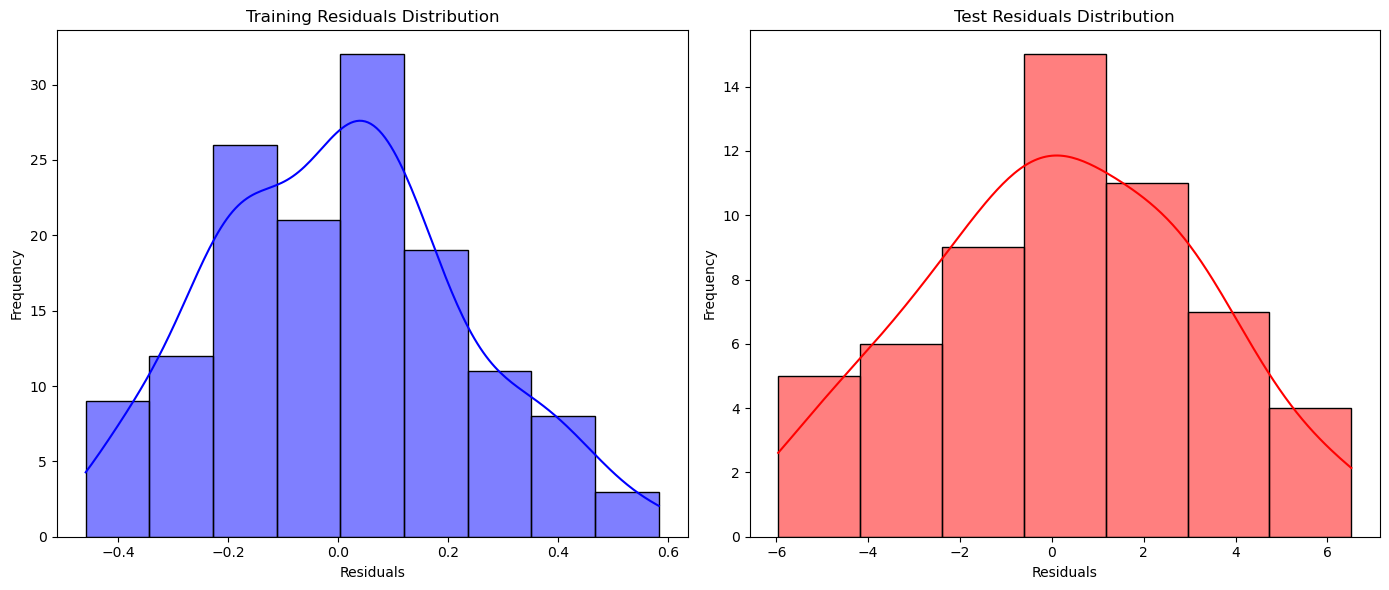

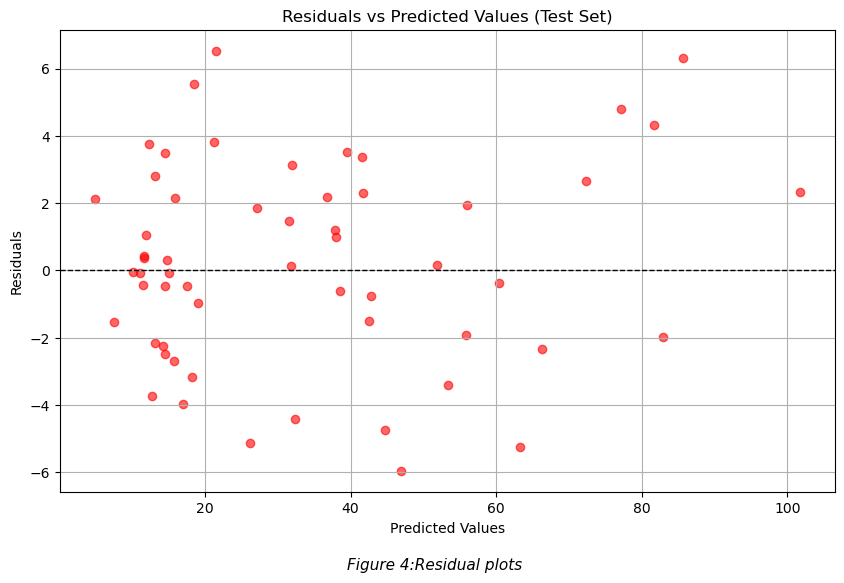

In [225]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred

# Plot training residuals
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True, color='blue')
plt.title('Training Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plot test residuals
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True, color='red')
plt.title('Test Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot of residuals vs predicted values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, test_residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values (Test Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.figtext(0.5, -0.02, 'Figure 4:Residual plots',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()


*Figure 4* provides an overview of the residuals for both the training and test sets, as well as the relationship between residuals and predicted values on the test set. The top-left plot displays the distribution of training residuals, which shows a roughly symmetric pattern centered around zero, indicating that the model’s predictions for the training data are unbiased and errors are fairly normally distributed. The top-right plot shows the test residuals, which also approximate a normal distribution but have a wider spread, suggesting slightly higher error variability in the test set compared to the training set.

The bottom plot illustrates the relationship between residuals and predicted values for the test set. Ideally, residuals should be randomly scattered around the horizontal axis (zero residual line) without any discernible pattern, which would indicate that the model's predictions do not systematically over- or under-predict for certain ranges of values. In this case, the residuals appear fairly scattered, although there are a few clusters. This plot helps to assess whether the model assumptions hold and whether further adjustments might improve the model's predictive accuracy. Overall, the visualizations suggest that the model performs well, with minor deviations observed in the test set residuals.

## 4.2- Feature importance

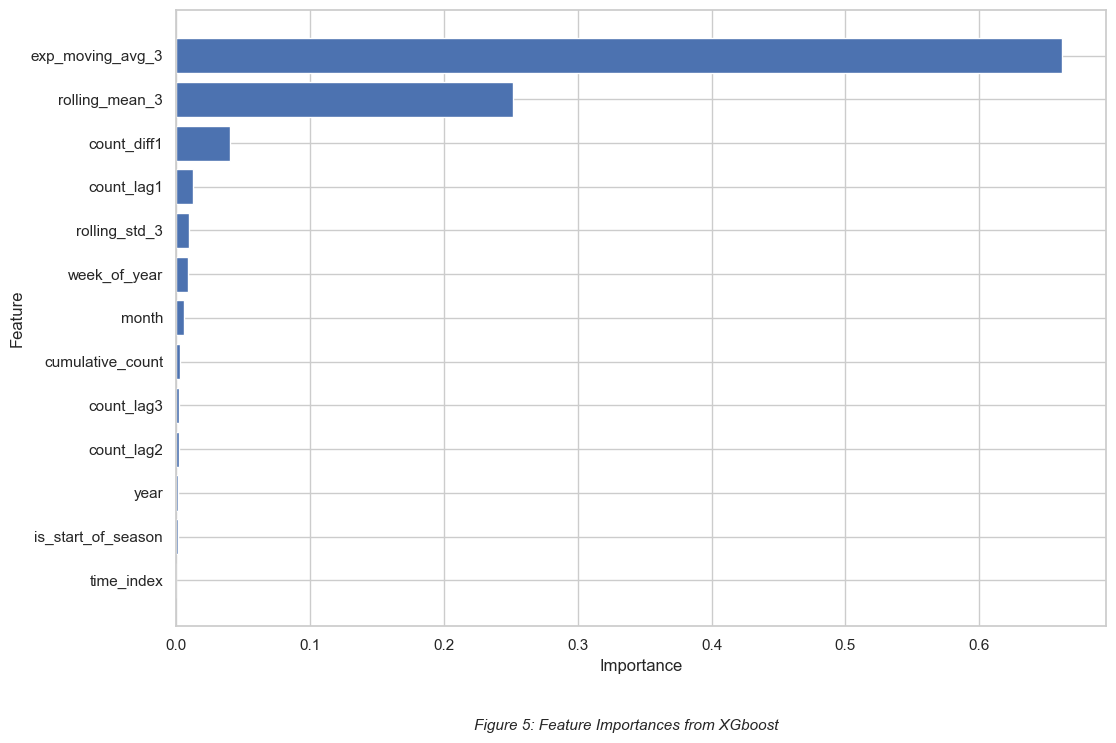

In [254]:
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top

# Save the figure
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.figtext(0.5, -0.02, 'Figure 5: Feature Importances from XGboost',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()

*Figure 5* displays feature importance values for a Decision Tree model used to predict COVID-19 hospitalization counts. Feature importance indicates how much each feature contributes to the model's predictions, with higher values representing greater influence on the model's decision-making.

In this case, exp_moving_avg_3 (the exponential moving average with a span of 3) is the most important feature by a significant margin, indicating that recent exponential averages of the target variable play a crucial role in predicting hospitalization counts. This suggests that the model relies heavily on recent smoothed trends in the data, which could capture short-term patterns and fluctuations effectively.
The second most important feature is rolling_mean_3, which represents a simple rolling average over the past three periods. This feature further emphasizes the importance of recent historical averages in predicting future hospitalizations. Together, these two moving average features capture the temporal trends and recent behavior in the time series, which the model has identified as highly predictive.
Other features, such as count_diff1 (the first difference of counts) and count_lag1 (the count from one period prior), have minor contributions, indicating that while they provide additional information, their influence on predictions is limited compared to the moving averages. Features like week_of_year, month, cumulative_count, and others have minimal importance, suggesting that the model does not rely on them significantly for this prediction task.

Overall, the model heavily depends on recent average trends rather than individual lagged counts or broader temporal features, indicating that short-term moving averages are the primary drivers of hospitalization forecasts in this Decision Tree model. This reliance on recent averages may work well for short-term predictions but could limit the model's ability to capture longer-term seasonal patterns or trends.

### 4.3- Forecasting
Now we will use the model to forecast the hospitalization count for the next 4 weeks

* In sample forecasting

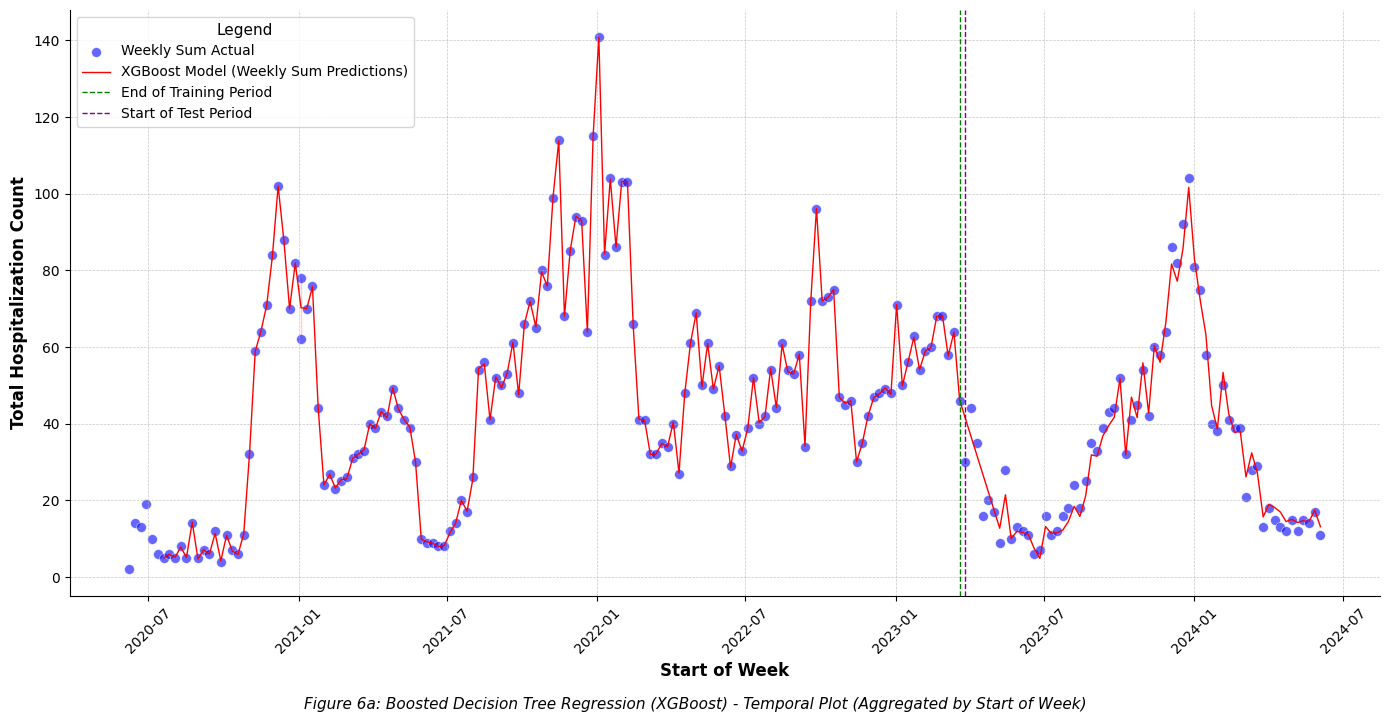

In [10]:
df['start_of_week'] = pd.to_datetime(df['year'].astype(str) + '-W' + df['week_of_year'].astype(str) + '-1', format='%Y-W%W-%w')
df = df.sort_values(by='start_of_week', ascending=True)

# Aggregate actual and predicted values by week and year
weekly_sum_actual = df.groupby(['year', 'week_of_year'])['count'].sum().reset_index()
weekly_sum_pred_train = train_data.copy()
weekly_sum_pred_train['predictions'] = y_train_pred
weekly_sum_pred_test = test_data.copy()
weekly_sum_pred_test['predictions'] = y_pred
weekly_sum_pred = pd.concat([weekly_sum_pred_train, weekly_sum_pred_test])
weekly_sum_pred = weekly_sum_pred.groupby(['year', 'week_of_year'])['predictions'].sum().reset_index()

# Create 'year_week' variable for plotting
weekly_sum_actual['year_week'] = pd.to_datetime(weekly_sum_actual['year'].astype(str) + '-' + weekly_sum_actual['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')
weekly_sum_pred['year_week'] = pd.to_datetime(weekly_sum_pred['year'].astype(str) + '-' + weekly_sum_pred['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')

# Define the train and test boundary dates
train_end_date = weekly_sum_actual['year_week'].iloc[train_size - 1]  # Last date in training
test_start_date = weekly_sum_actual['year_week'].iloc[train_size]     # First date in test

# Plot the actual and predicted values
plt.figure(figsize=(14, 7))
sns.scatterplot(data=weekly_sum_actual, x='year_week', y='count', label='Weekly Sum Actual', color='blue', alpha=0.6, s=50)
sns.lineplot(data=weekly_sum_pred, x='year_week', y='predictions', label='XGBoost Model (Weekly Sum Predictions)', color='red', linewidth=1)

# Add vertical lines for the train/test boundary
plt.axvline(x=train_end_date, color='green', linestyle='--', linewidth=1, label='End of Training Period')
plt.axvline(x=test_start_date, color='purple', linestyle='--', linewidth=1, label='Start of Test Period')

# Set labels, title, and legend
plt.xlabel('Start of Week', fontsize=12, fontweight='bold')
plt.ylabel('Total Hospitalization Count', fontsize=12, fontweight='bold')
plt.title('', fontsize=14, fontweight='bold', fontstyle='italic')
plt.xticks(rotation=45)
plt.legend(title='Legend', fontsize=10, title_fontsize=11, loc='upper left')
sns.despine()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 6a: Boosted Decision Tree Regression (XGBoost) - Temporal Plot (Aggregated by Start of Week)',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()


* Out of sample forecasting 

In [11]:
hospital['EARLIEST_RPT_TO_ST_DT'] = pd.to_datetime(hospital['EARLIEST_RPT_TO_ST_DT'])
hospital['start_of_week'] = hospital['EARLIEST_RPT_TO_ST_DT'].dt.to_period('W').apply(lambda x: x.start_time)

hospital = hospital.sort_values(by='start_of_week', ascending=True)

hospital_agg = hospital.groupby(['start_of_week']).agg({'HSPTLIZD_IND': 'sum'}).reset_index()
hospital_agg.rename(columns={'HSPTLIZD_IND': 'count'}, inplace=True)

hospital_agg.loc[:, 'year'] = hospital_agg['start_of_week'].dt.year
hospital_agg.loc[:, 'month'] = hospital_agg['start_of_week'].dt.month
hospital_agg.loc[:, 'week_of_year'] = hospital_agg['start_of_week'].dt.isocalendar().week


#hospital_agg = hospital_agg.sort_values(by='start_of_week', ascending=True)

#merged_df = pd.merge(hospital_agg, early_indicators, on='start_of_week', how='inner')
df=hospital_agg.copy()
#df= hospital_agg.drop(columns=['start_of_week'])

# 1. Lag Features
df['count_lag1'] = df['count'].shift(1)
df['count_lag2'] = df['count'].shift(2)
df['count_lag3'] = df['count'].shift(3)

# 2. Rolling Statistics
df['rolling_mean_3'] = df['count'].rolling(window=3).mean()
df['rolling_std_3'] = df['count'].rolling(window=3).std()

# 3. Interaction Terms
#df['month_day_interaction'] = df['month'] * df['day_of_week']

# 4. Time Features
df['is_start_of_season'] = df['month'].apply(lambda x: 1 if x in [3, 6, 9, 12] else 0)

# 6. Cumulative Counts
df['cumulative_count'] = df['count'].cumsum()

# 7. Difference Features
df['count_diff1'] = df['count'] - df['count'].shift(1)

# 8. Exponential Moving Average
df['exp_moving_avg_3'] = df['count'].ewm(span=3, adjust=False).mean()
#df['exp_moving_avg_2'] = df['count'].ewm(span=2, adjust=False).mean()
#df['exp_moving_avg_1'] = df['count'].ewm(span=1, adjust=False).mean()
# Drop rows with missing values due to lagging or rolling operations
df.dropna(inplace=True)
df['time_index'] = np.arange(1, len(df) + 1)
#df= df.iloc[:184]
df_start = df.drop(columns=['start_of_week'])
df_predict = df.drop(columns=['count','start_of_week'])

     year  week_of_year  month      count  count_lower  count_upper
0  2024.0            24    6.0  11.453509     9.333411    14.052876
1  2024.0            25    6.0  12.603124    10.352664    14.616082
2  2024.0            26    6.0  12.164731    10.612857    14.125616
3  2024.0            27    6.0  12.335135    10.802737    14.487967


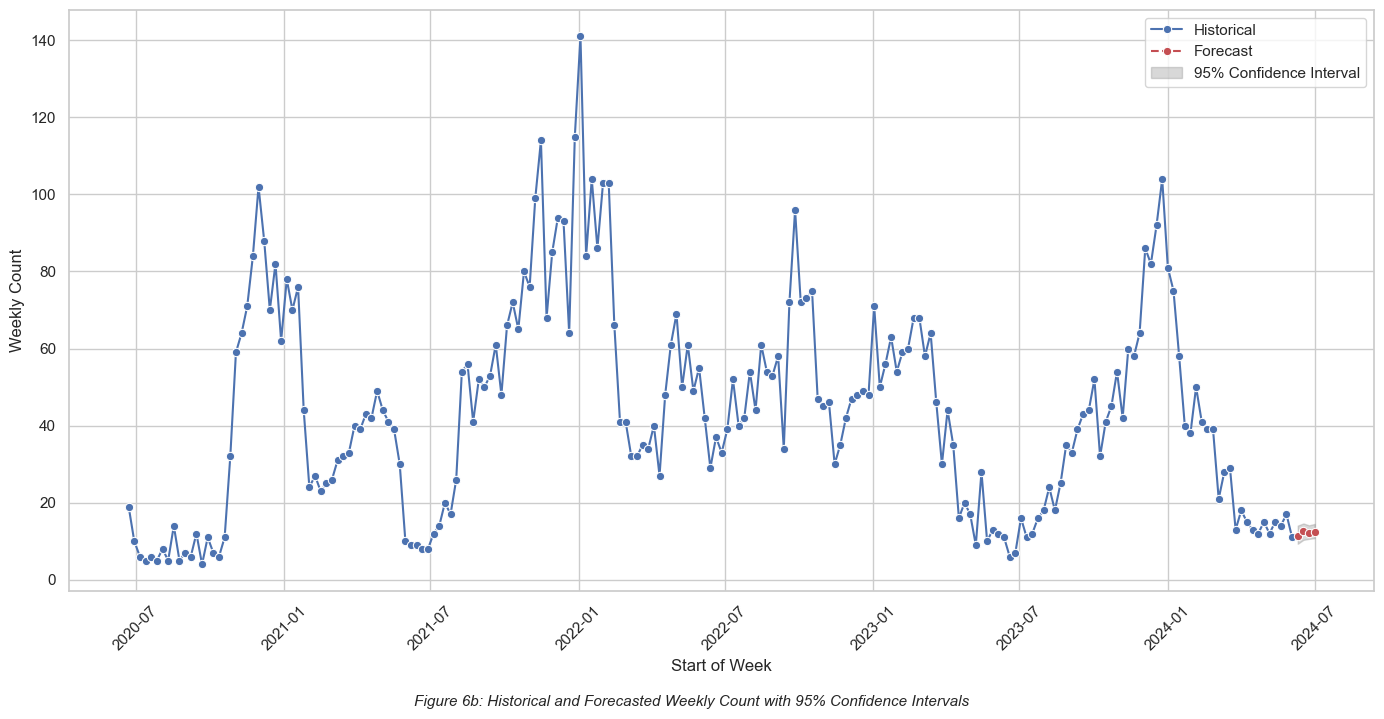

In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare training data
X_train = df.drop(columns=['count','start_of_week'])
y_train = df['count']

# Parameters
n_bootstraps = 100
n_forecast_weeks = 4
confidence_level = 0.95
lower_percentile = (1.0 - confidence_level) / 2.0 * 100
upper_percentile = (1.0 + confidence_level) / 2.0 * 100

# Bootstrapping
bootstrap_models = []
for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=42+i)
    model = XGBRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate=0.1, subsample=0.6)
    model.fit(X_resampled, y_resampled)
    bootstrap_models.append(model)

# Forecasting
forecast_start = df_start.iloc[-1].copy()
forecast_weeks = pd.DataFrame()
forecast_year = forecast_start['year']
current_week = int(forecast_start['week_of_year'] + 1)
weeks_ahead = 4
all_bootstrap_preds = pd.DataFrame()

for week in range(current_week, current_week + weeks_ahead):
    if week > 52:
        week -= 52
    
    forecast_data = {
        'year': forecast_year,
        'month': forecast_start['month'],
        'week_of_year': week,
        'count_lag1': forecast_start['count'],
        'count_lag2': forecast_start['count_lag1'],
        'count_lag3': forecast_start['count_lag2'],
        'rolling_mean_3': forecast_start[['count', 'count_lag1', 'count_lag2']].mean(),
        'rolling_std_3': forecast_start[['count', 'count_lag1', 'count_lag2']].std(),
        'is_start_of_season': 1 if forecast_start['month'] in [3, 6, 9, 12] else 0,
        'cumulative_count': forecast_start['cumulative_count'] + forecast_start['count'],
        'count_diff1': forecast_start['count'] - forecast_start['count_lag1'],
        'exp_moving_avg_3': forecast_start[['count', 'count_lag1', 'count_lag2']].ewm(span=3, adjust=False).mean().iloc[-1],
        'time_index': forecast_start['time_index']
    }
    
    forecast_input = pd.DataFrame([forecast_data])
    forecast_input = forecast_input[X_train.columns]
    
    bootstrap_preds = [model.predict(forecast_input)[0] for model in bootstrap_models]
    all_bootstrap_preds = pd.concat([all_bootstrap_preds, pd.DataFrame({'week': [week] * len(bootstrap_preds), 'pred': bootstrap_preds})], ignore_index=True)

    
    predicted_count = np.mean(bootstrap_preds)
    forecast_data['count'] = predicted_count
    forecast_weeks = pd.concat([forecast_weeks, pd.DataFrame([forecast_data])], ignore_index=True)
    
    forecast_start['count'] = predicted_count
    forecast_start['count_lag2'] = forecast_start['count_lag1']
    forecast_start['count_lag1'] = predicted_count

# Define confidence level
confidence_level = 0.99  # 99% confidence level
lower_percentile = (1.0 - confidence_level) / 2.0 * 100  # 0.5 percentile
upper_percentile = (1.0 + confidence_level) / 2.0 * 100  # 99.5 percentile

# Calculate confidence intervals
forecast_weeks['count_lower'] = forecast_weeks['week_of_year'].apply(
    lambda w: np.percentile(all_bootstrap_preds[all_bootstrap_preds['week'] == w]['pred'], lower_percentile)
)
forecast_weeks['count_upper'] = forecast_weeks['week_of_year'].apply(
    lambda w: np.percentile(all_bootstrap_preds[all_bootstrap_preds['week'] == w]['pred'], upper_percentile)
)


print(forecast_weeks[['year', 'week_of_year', 'month', 'count', 'count_lower', 'count_upper']])

# Plotting
historical_weekly = df[['start_of_week', 'count']]
forecast_weeks['start_of_week'] = pd.date_range(start=df['start_of_week'].iloc[-1] + pd.Timedelta(weeks=1), periods=weeks_ahead, freq='W-MON')

sns.set_theme(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.lineplot(data=historical_weekly, x='start_of_week', y='count', label='Historical', marker='o', color='b')
sns.lineplot(data=forecast_weeks, x='start_of_week', y='count', label='Forecast', marker='o', linestyle='--', color='r')
plt.fill_between(forecast_weeks['start_of_week'],
                 forecast_weeks['count_lower'],
                 forecast_weeks['count_upper'],
                 color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xticks(rotation=45)
plt.xlabel('Start of Week')
plt.ylabel('Weekly Count')
plt.legend()
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 6b: Historical and Forecasted Weekly Count with 95% Confidence Intervals',
            ha='center', fontsize=11, fontstyle='italic')
plt.show()


In [ ]:
plt.fill_between(
    forecast_weeks['start_of_week'],
    forecast_weeks['count_lower'],
    forecast_weeks['count_upper'],
    color='gray',
    alpha=0.3,
    label=f'{confidence_level * 100:.0f}% Confidence Interval'
)


* Complete time series with test and forecast horizon 

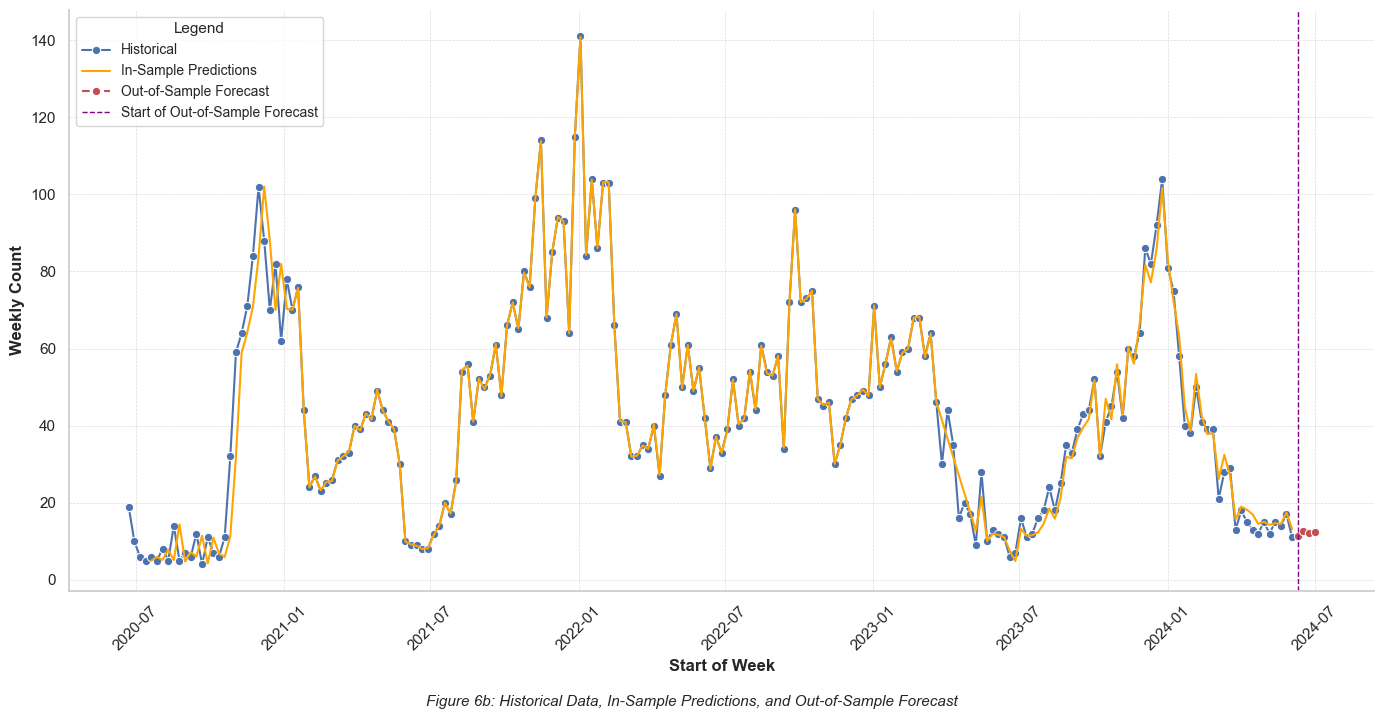

In [27]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=historical_weekly, x='start_of_week', y='count', label='Historical', marker='o', color='b')

# Plot in-sample predictions (if available)
sns.lineplot(data=weekly_sum_pred, x='year_week', y='predictions', label='In-Sample Predictions', linestyle='-', color='orange')

# Plot out-of-sample forecast data
sns.lineplot(data=forecast_weeks, x='start_of_week', y='count', label='Out-of-Sample Forecast',marker='o',  linestyle='--', color='r')

# Add vertical line for the start of the out-of-sample forecast period
forecast_start_date = forecast_weeks['start_of_week'].min()
plt.axvline(x=forecast_start_date, color='purple', linestyle='--', linewidth=1, label='Start of Out-of-Sample Forecast')

# Enhance plot readability
plt.xticks(rotation=45)
plt.xlabel('Start of Week', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Count', fontsize=12, fontweight='bold')
plt.legend(title='Legend', fontsize=10, title_fontsize=11, loc='upper left')
sns.despine()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 6b: Historical Data, In-Sample Predictions, and Out-of-Sample Forecast',
            ha='center', fontsize=11, fontstyle='italic')

# Show the plot
plt.show()


The forecasted points align with the recent downward trend, indicating that the model has captured the recent decrease in cases and expects this pattern to persist in the immediate future. However, the short horizon of the forecast means that while the model may be reliable for near-term predictions, it does not extend far enough to capture potential longer-term trends or upcoming seasonal surges that have been observed in the past.


# V- Discussion
## 4.1- Advantages and limitations of the model 
The XGBoost model offers several advantages for forecasting weekly COVID-19 hospitalization counts. It provides strong short-term predictive accuracy, aligning well with recent trends in the data, which is valuable for immediate planning and resource allocation by public health agencies. The model effectively captures temporal dependencies through features like lagged counts and rolling means, and its flexibility allows it to handle complex patterns in large datasets. Additionally, XGBoost provides insights into feature importance, helping identify key drivers of hospitalization trends. However, the model has limitations in its ability to make long-term forecasts, as it relies heavily on recent patterns and may struggle to anticipate sudden trend changes, such as those caused by new variants or shifts in public health policies. There is also a risk of overfitting, particularly with complex models like XGBoost, which may affect its generalization to new data. While the model captures seasonality to an extent, it may not be as robust in this regard as classical time series models, such as SARIMA, which are specifically designed to account for seasonal patterns. Overall, while XGBoost is a powerful tool for short-term forecasting, integrating it with other time series models in future work could enhance its effectiveness for long-term predictions and improve its resilience to abrupt changes in trend.

## 4.2- Recommendation for next step
As a next step, we recommend developing a forecast ensemble that combines advanced machine learning models, such as LSTM or GRU recurrent neural networks, with traditional statistical methods like SARIMAX. This ensemble approach would leverage the strengths of each model type to provide a more comprehensive and accurate prediction of weekly COVID-19 hospitalization rates. LSTM and GRU models excel at capturing complex temporal dependencies and non-linear patterns, which could enhance the model’s adaptability to sudden changes in trends, such as those driven by new variants or public health interventions(13). Meanwhile, SARIMAX is particularly adept at modeling seasonality and autoregressive patterns with interpretability, making it highly suitable for capturing long-term trends and cyclical behaviors in the data.

By integrating these methods, an ensemble model can capitalize on the unique strengths of each approach: LSTM or GRU models’ ability to learn intricate patterns in the data, and SARIMAX’s strength in capturing regular seasonal fluctuations and time-dependent structures. Additionally, such an ensemble would provide a more robust forecast, as the combined predictions are likely to be less sensitive to the individual limitations of each model, thereby improving both short- and long-term forecast accuracy. This hybrid approach could be especially beneficial in healthcare forecasting, where accurate predictions of hospitalization rates are critical for effective resource planning and policy-making.

In summary, building an ensemble model that incorporates both deep learning architectures (LSTM or GRU) and classical time series models like SARIMAX would likely improve the accuracy and robustness of our forecasts. This approach would yield a more comprehensive tool for tracking and predicting weekly hospitalization rates, offering a valuable resource for public health agencies in their ongoing response to COVID-19.

# VI- Conclusion

In conclusion, this study evaluated and compared three machine learning models—Decision Tree, Random Forest, and XGBoost—to forecast weekly COVID-19 hospitalization rates. Among these, XGBoost demonstrated the highest accuracy and generalizability, particularly in the short term, as it effectively captured temporal patterns in the data through engineered features such as lagged counts, rolling means, and seasonality indicators. However, while XGBoost performed well over recent trends, its reliance on short-term patterns highlighted limitations in forecasting accuracy over extended periods, especially in the face of abrupt trend shifts.To enhance predictive power and robustness, we recommend exploring ensemble approaches that integrate advanced recurrent neural network architectures (LSTM or GRU) with classical time series models like SARIMAX.

## Bibliography

1-Centers for Disease Control and Prevention (CDC). (2024). Center for Forecasting and Outbreak Analytics. Retrieved from https://www.cdc.gov/forecast-outbreak-analytics/publicationsandresources/index.html

2-Maine Center for Disease Control and Prevention. (2024). COVID-19 vaccination and public health measures. Retrieved from https://www.maine.gov/dhhs/mecdc

3-Box, G. E. P., & Jenkins, G. M. (1976). Time Series Analysis: Forecasting and Control (2nd ed.). Holden-Day.

4-Brownlee, J. (2020). Introduction to Time Series Forecasting with Python: How to Prepare Data and Develop Models to Predict the Future. Machine Learning Mastery.

5-Chakraborty, T., & Ghosh, I. (2020). Real-time forecasts and risk assessment of novel coronavirus (COVID-19) cases: A data-driven analysis. Chaos, Solitons & Fractals, 135, 109850. https://doi.org/10.1016/j.chaos.2020.109850

6-James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning: With Applications in R. Springer.

7-Breiman, L., Friedman, J. H., Olshen, R. A., & Stone, C. J. (1984). Classification and regression trees. Wadsworth.

8-Chen, T., & Guestrin, C. (2016, August). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’16) (pp. 785–794). ACM. https://doi.org/10.1145/2939672.2939785

9-Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: Principles and Practice (2nd ed.). OTexts.

10-U.S. Census Bureau. (2023). American Consumer Survey: Age and Sex - Census Bureau tables. Retrieved August 25, 2023, from https://www.data.census.gov/tableq=Age%20and%20Sex&g=040XX00US23

11-Centers for Disease Control and Prevention (CDC). (2024). COVID-19 Data Tracker. Retrieved from https://covid.cdc.gov/covid-data-tracker/#datatracker-home

12-Tyralis, H., & Papacharalampous, G. (2017). Feature Selection for Time Series Forecasting with Random Forest. Journal of Hydrology.

13-Jin, Y., Wang, R., Zhuang, X., Wang, K., Wang, H., Wang, C., & Wang, X. (2022). Prediction of COVID-19 data using an ARIMA-LSTM hybrid forecast model. Mathematics, 10(21), 4001. https://doi.org/10.3390/math1021400114001.



## Appendix (Additional graphs )

## Plot of model predicitons vs test set

## Forecast zoom

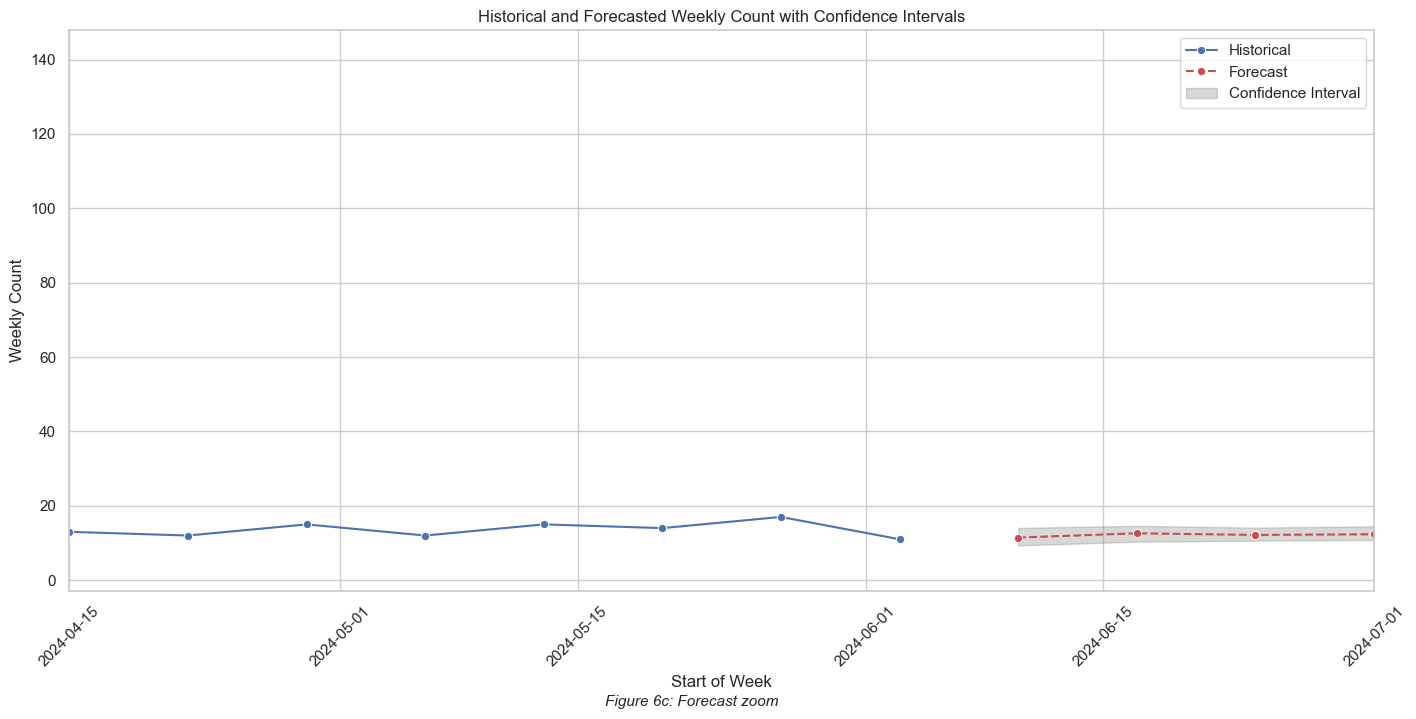

In [26]:
# Plot both historical and forecasted counts with confidence intervals
plt.figure(figsize=(14, 7))

# Plot historical data
sns.lineplot(data=historical_weekly, x='start_of_week', y='count', label='Historical', marker='o', color='b')

# Plot forecasted data
sns.lineplot(data=forecast_weeks, x='start_of_week', y='count', label='Forecast', marker='o', linestyle='--', color='r')

# Plot confidence intervals
plt.fill_between(
    forecast_weeks['start_of_week'],
    forecast_weeks['count_lower'],
    forecast_weeks['count_upper'],
    color='gray',
    alpha=0.3,
    label='Confidence Interval'
)

# Enhancing plot readability
plt.xticks(rotation=45)
plt.xlabel('Start of Week')
plt.ylabel('Weekly Count')
plt.title('Historical and Forecasted Weekly Count with Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.figtext(0.5, -0.02, 'Figure 6c: Forecast zoom',
            ha='center', fontsize=11, fontstyle='italic')

# Zoom in on the last section to see forecast points
plt.xlim(historical_weekly['start_of_week'].iloc[-8], forecast_weeks['start_of_week'].iloc[-1])
# Save the graph as a file
plt.savefig('forecast_zoom.png', dpi=300, bbox_inches='tight')

plt.show()


## Partial dependency Plots

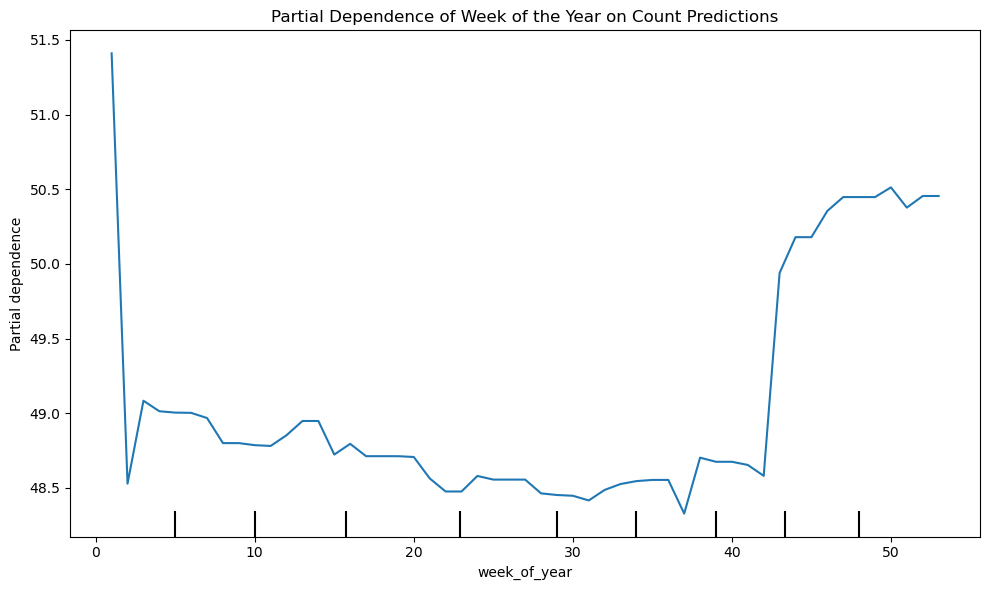

In [203]:
# Partial Dependence Plot for 'week_of_year'
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(xgb, X_train, features=['week_of_year'], ax=ax)
plt.title('Partial Dependence of Week of the Year on Count Predictions')
plt.tight_layout()
plt.show()

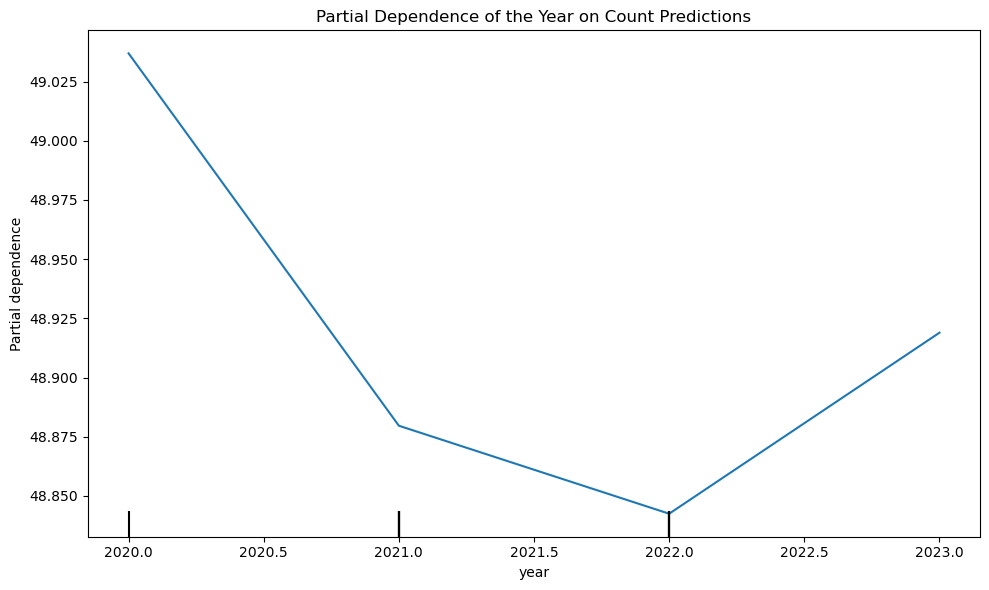

In [209]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(xgb, X_train, features=['year'], ax=ax)
plt.title('Partial Dependence of the Year on Count Predictions')
plt.tight_layout()
plt.show()

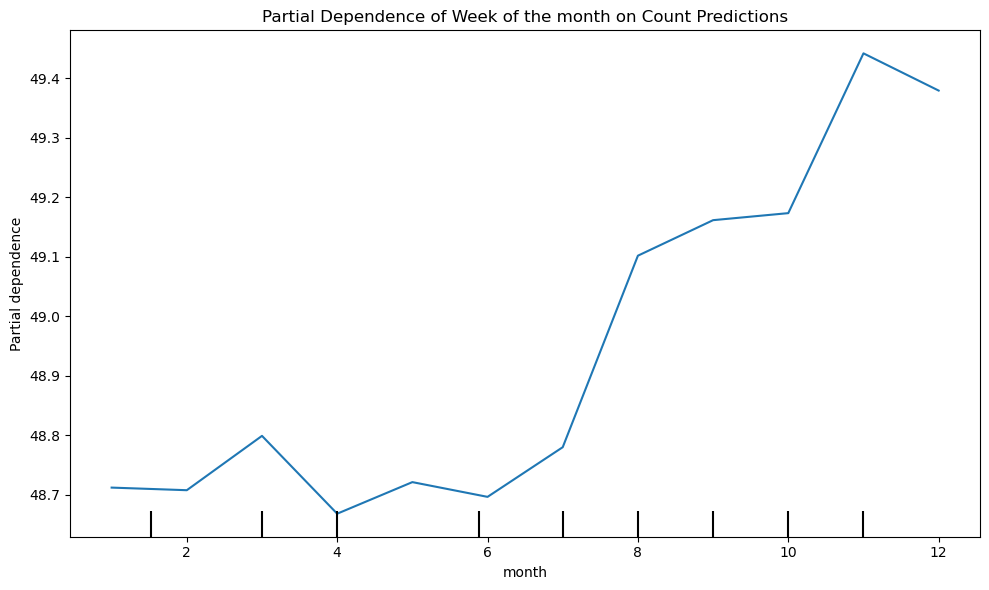

In [211]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(xgb, X_train, features=['month'], ax=ax)
plt.title('Partial Dependence of Week of the month on Count Predictions')
plt.tight_layout()
plt.show()

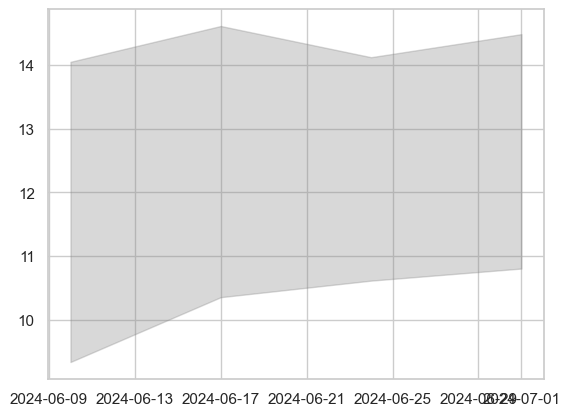

In [21]:
plt.fill_between(
    forecast_weeks['start_of_week'],
    forecast_weeks['count_lower'],
    forecast_weeks['count_upper'],
    color='gray',
    alpha=0.3,
    label=f'{confidence_level * 100:.0f}% Confidence Interval'
)
